# Earth Modeling PRioritized Event Selection Scheme (EMPRESS)

Developed by Claire Richardson (Arizona State University), Fall 2024

In collaboration with Ed Garnero (Arizona State University) and Ebru Bozdag (Colorado School of Mines)

For detailed usage notes, refer to README.md (https://github.com/claire-richardson/EMPRESS.git)

-----
## PART 1: Define the modeling region of interest
Use Part 1 in conjunction with `box_sampling_input.py` to visualize and define a 3D box around the region of interest. From usage notes:

<blockquote>
define the following variables in `box_sampling_input.py`:

- `width` - longitudinal extent of the box in degrees
- `height` - latitudinal extent of the box in degrees
- `south` - latitude that defines the southernmost extent of the box in degrees 
- `west` - longitude that defines the westernmost extent of the box in degrees 
- `box_depth_min` - depth that defines the top of the box in km
- `box_depth_max` - depth that defines the bottom/base of the box in km

and then run `PART 1` of `EMPRESS.ipynb`. If the box doesn't cover the target region appropriately, update `box_sampling_input.py` and rerun `PART 1`. Do this until a satisfactory box has been defined.
</blockquote>




#### Import initial modules and define plotting functions:

In [1]:
import os
import geo_math
import refmodels
import numpy as np
import pandas as pd
import matplotlib as mpl
import box_sampling_input
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import matplotlib.patches as mpatches

def convert_azimuth(az):
    '''
    Function to convert azimuth range from 0 - 360 degrees to 0 - 180 degrees
    ======
    Inputs:
    - `az`: azimuth [format: float or int; unit: degrees]
    Outputs:
    - converted azimuth [format: float or int; unit: degrees]
    ======
    '''
    if az >= 180.:
        return az - 180.
    else:
        return az

def find_cloud_center(lats, lons):
    '''
    Function to find the geographical center of a cloud of coordinates
    ======
    Inputs:
    - `lats`: 1D array of latitudes of the points in the cloud [format: 1D array-like; unit: degrees]
    - `lons`: 1D array of longitudes of the points in the cloud [format: 1D array-like; unit: degrees]
    Outputs:
    - latitude and longitude of geographical cloud center [format: list of two floats; unit: degrees]
    ======
    '''
    lat_rad = np.radians(lats)
    lon_rad = np.radians(lons)
    cloud_x = np.mean(np.cos(lon_rad) * np.cos(lat_rad))
    cloud_y = np.mean(np.sin(lon_rad) * np.cos(lat_rad))
    cloud_z = np.mean(np.sin(lat_rad))

    cloud_lat = np.degrees(np.arcsin(cloud_z / 1.))
    cloud_lon = np.degrees(np.arctan2(cloud_y, cloud_x))
    
    if cloud_lon >= 180.:
        cloud_lon -= 360.
    if cloud_lon < -180:
        cloud_lon += 360

    return [cloud_lat, cloud_lon]

def dist_from_point(start_lat, start_lon, end_lats, end_lons):
    '''
    Function to find the epicentral distance from one starting point to an array of end points
    ======
    Inputs:
    - `start_lat`: latitude of the starting point [format: float or int; unit: degrees]
    - `start_lon`: longitude of the starting point [format: float or int; unit: degrees]
    - `end_lats`: 1D array of latitudes of the end points [format: 1D array-like; unit: degrees]
    - `end_lons`: 1D array of longitudes of the end points [format: 1D array-like; unit: degrees]
    Outputs:
    - a 1D array of epicentral distances from the starting point to the end points [format: 1D array-like; unit: degrees]
    ======
    '''
    start_lat_rad = np.radians(start_lat)
    start_lon_rad = np.radians(start_lon + 180.)
    end_lats_rad = np.radians(end_lats)
    end_lons_rad = np.radians(end_lons + 180.)
    
    a = (np.sin((end_lats_rad - start_lat_rad) / 2) ** 2) + np.cos(start_lat_rad) * np.cos(end_lats_rad) * (np.sin((end_lons_rad - start_lon_rad) / 2) ** 2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return np.degrees(c)
    
def az_from_point(start_lat, start_lon, end_lats, end_lons):
    '''
    Function to find the azimuths from one starting point to an array of end points
    ======
    Inputs:
    - `start_lat`: latitude of the starting point [format: float or int; unit: degrees]
    - `start_lon`: longitude of the starting point [format: float or int; unit: degrees]
    - `end_lats`: 1D array of latitudes of the end points [format: 1D array-like; unit: degrees]
    - `end_lons`: 1D array of longitudes of the end points [format: 1D array-like; unit: degrees]
    Outputs:
    - a 1D array of azimuths from the starting point to the end points [format: 1D array-like; unit: degrees]
    ======
    '''
    delta_lat = end_lats - start_lat
    delta_lon = end_lons - start_lon
        
    start_lat_rad = np.radians(start_lat)
    start_lon_rad = np.radians(start_lon)
    end_lats_rad = np.radians(end_lats)
    end_lons_rad = np.radians(end_lons)
        
    delta_lat_rad = np.radians(delta_lat)
    delta_lon_rad = np.radians(delta_lon)
    
    az_rad = np.arctan2((np.sin(delta_lon_rad) * np.cos(end_lats_rad)), (np.cos(start_lat_rad) * np.sin(end_lats_rad) - np.sin(start_lat_rad) * np.cos(end_lats_rad) * np.cos(delta_lon_rad)))
    az = np.degrees(az_rad)
    
    az = az.mask((az < 0.), (360 - abs(az)))
    az = az.mask((az == 360), 0)
    
    return az

def az_diff(az1, az2):
    '''
    Function to find the absolute (i.e., <= 180 degrees) angular difference between a starting azimuth and an array of other azimuths
    ======
    Inputs:
    - `az1`: starting azimuth [format: float or int; unit: degrees]
    - `az2`: 1D array of other azimuths [format: 1D array-like; unit: degrees]
    Outputs:
    - a 1D array of angular differences between the starting azimuth and azimuths in az2 [format: 1D array-like; unit: degrees]
    ======
    '''
    az_diff_series = abs(az1 - az2)
    az_diff_series = az_diff_series.mask((az_diff_series > 180), (360 - az_diff_series))

    return az_diff_series

def find_nearest(array, value, type):
    '''
    Function to find the nearest value or values in an array to a given value
    ======
    Inputs:
    - `array`: array of values to query for the closest value [format: 1D array-like; unit: numeric]
    - `value`: given value to find the closest `array` values [format: float or int; unit: numeric]
    - `type`: type of closest value to find, either 'absolute' (i.e., find the singular closest absolute value) or 'bounds' (i.e., find the closest values on either side of the given value [format: string]
    Outputs:
    - either one index (`type` == 'absolute') or two indices (`type` == 'bounds') of the closest points in `array` to `value` [format: int; unit: index]
    ======
    '''
    if type == 'absolute':
        array_diff = abs(array - value)
        id = np.where(array_diff == array_diff.min())[0][0]
        return [id]
    
    elif type == 'bounds':
        array_diff = array - value
        smallest_negative_value = array_diff[np.where(array_diff <= 0)].max()
        smallest_positive_value = array_diff[np.where(array_diff >= 0)].min()
        negative_id = np.where(array_diff == smallest_negative_value)[0][0]
        positive_id = np.where(array_diff == smallest_positive_value)[0][0]
        return [negative_id, positive_id]

def lateral_grid_register(df_model, model_wave_type, model_depth, coord_increment, column_name, model_value_type):
    '''
    Function to convert a tomography model CSV into a plottable gridded array at a given depth. Currently supports models given in perturbations relative to a reference model, or velocities from models made relative to PREM (Dziewonski & Anderson, 1981)
    ======
    Inputs:
    - `df_model` - pandas dataframe of the whole tomography model (model file should be stored as /EMPRESS/models/{model}.csv) [format: Pandas dataframe]
    - `model_wave_type` - wave polarity to plot (either 'S' or 'P') [format: string]
    - `model_depth` - depth at which to plot the model [format: int or float; unit: km]
    - `coord_increment` - grid spacing / resolution [format: int; unit: degrees]
    - `column_name` - header name in pandas dataframe of the value to plot [format: string]
    - `model_value_type` - type of velocity value in `column_name`, either 'velocity' if model values are given in km/s, or 'perturbation' if model values are given as percent perturbations from a reference model [format: string]
    Outputs:
    - plottable gridded 2D array of model values [format: 2D numpy array; unit: `column_name` units]
    ======
    '''
    prem_vel = refmodels.prem_vel(model_wave_type, model_depth)
    model_depths = df_model.depth.unique()
    array_diff = abs(model_depths - model_depth)
    id = np.where(array_diff == array_diff.min())[0][0]
    ar_model_depth = np.array(df_model.loc[df_model['depth'] == model_depths[id]][['latitude', 'longitude', column_name]].reset_index(drop = True))
    
    reg_lats = np.arange(-90, 90, coord_increment)
    reg_lons = np.arange(-180, 180, coord_increment)
    ar = np.zeros((len(reg_lons), len(reg_lats)))

    lat_idx = 0
    for lat in reg_lats:
        lat_diff = abs(ar_model_depth.T[0] - lat)
        ar_closest_lat = ar_model_depth[np.where(lat_diff == lat_diff.min())[0]]

        lon_idx = 0
        for lon in reg_lons:
            lon_diff = abs(ar_closest_lat.T[1] - lon)
            closest_id = np.where(lon_diff == lon_diff.min())[0][0]
            model_value = ar_closest_lat.T[-1, closest_id]

            if model_value_type == 'velocity':
                if model_value == 0.:
                    model_value = 0.
                else:
                    model_value = ((model_value / prem_vel) * 100.) - 100.
                    
            ar[lon_idx, lat_idx] = model_value
            lon_idx += 1
            
        lat_idx += 1

    ar = ar.T
    return ar

def radial_grid_register(df_model, model_wave_type, start_lat, start_lon, end_lat, end_lon, coord_increment, column_name, model_value_type):
    '''
    Function to convert a tomography model CSV into a plottable gridded array along a given cross-section. Currently supports models given in perturbations relative to a reference model, or velocities from models made relative to PREM (Dziewonski & Anderson, 1981)
    ======
    Inputs:
    - `df_model` - pandas dataframe of the whole tomography model (model file should be stored as /EMPRESS/models/{model}.csv) [format: Pandas dataframe]
    - `model_wave_type` - wave polarity to plot (either 'S' or 'P') [format: string]
    - `start_lat` - starting latitude of the cross-section [format: float or int; unit: degrees]
    - `start_lon` - starting longitude of the cross-section [format: float or int; unit: degrees]
    - `end_lat` - ending latitude of the cross-section [format: float or int; unit: degrees]
    - `end_lon` - ending longitude of the cross-section [format: float or int; unit: degrees]
    - `coord_increment` - grid spacing / resolution [format: int; unit: degrees]
    - `column_name` - header name in pandas dataframe of the value to plot [format: string]
    - `model_value_type` - type of velocity value in `column_name`, either 'velocity' if model values are given in km/s, or 'perturbation' if model values are given as percent perturbations from a reference model [format: string]
    Outputs:
    - plottable gridded 2D array of model values [format: 2D numpy array; unit: `column_name` units]
    ======
    '''
    ar_model = np.array(df_model[['depth', 'latitude', 'longitude', column_name]])
    model_depths = list(df_model.depth.unique())
    x_section_length = geo_math.GCP_length(start_lat, start_lon, end_lat, end_lon)
    x_section_increments = int(x_section_length / coord_increment)
    x_section_increment_length =  x_section_length / x_section_increments
    ar = np.zeros((len(model_depths), x_section_increments + 1))
    
    depth_idx = 0
    for model_depth in model_depths:

        ar_depth = ar_model[np.where(ar_model.T[0] == model_depth)[0]]
        prem_vel = refmodels.prem_vel(model_wave_type, model_depth)
    
        total_dist_along_path = 0
        inc_idx = 0
        for increment in range(x_section_increments + 1):
            # find the closest model value to each incremental point
            # first, find the incremental point
            point_along_path = geo_math.GCP_point(start_lat, start_lon, end_lat, end_lon, x_section_length, total_dist_along_path)
            
            # then, find the nearest model value
            lat_diff = abs(ar_depth.T[1] - point_along_path[0])
            ar_closest_lat = ar_depth[np.where(lat_diff == lat_diff.min())[0]]
    
            lon_diff = abs(ar_closest_lat.T[2] - point_along_path[1])
            closest_pt = ar_closest_lat[np.where(lon_diff == lon_diff.min())[0][0]]
    
            model_value = closest_pt[-1]

            if model_value_type == 'velocity':
                if model_value == 0.:
                    model_value = 0.
                else:
                    model_value = ((model_value / prem_vel) * 100.) - 100.
    
            ar[depth_idx, inc_idx] = model_value
            total_dist_along_path += x_section_increment_length
            inc_idx += 1
            
        depth_idx += 1
    
    return ar

def make_equal_area_grid(side_length, start_lat, start_lon, end_lat, end_lon):
    '''
    Function to make a lateral grid of approximate equal area blocks
    ======
    Inputs:
    - `side_length` - side lengths of the reference grid block at the equator. Must be divisible into both the total latitudinal and longitudinal extent of the lateral area to be gridded [format: int; unit: degrees]
    - `start_lat` - starting latitude of the lateral area to be gridded (southernmost latitude) [format: float or int; unit: degrees]
    - `start_lon` - starting longitude of the lateral area to be gridded (westernmost longitude) [format: float or int; unit: degrees]
    - `end_lat` - ending latitude of the lateral area to be gridded (northernmost latitude) [format: float or int; unit: degrees]
    - `end_lon` - ending longitude of the lateral area to be gridded (easternmost longitude) [format: float or int; unit: degrees]
    Outputs:
    - pandas dataframe of approximate equal area 2D grid blocks for the lateral area defined by `start_lat`, `start_lon`, `end_lat`, and `end_lon` with approximate equal area block dimensions
    ======
    '''
    # presets:
    rad = 6371 # radius
    latitude = []
    circumference_per_lat = []
    
    if (start_lon > 0.) and (end_lon < 0.):
        total_lon = (180 - start_lon) + (180 + end_lon)
    else:
        total_lon = end_lon - start_lon
    
    total_lat = start_lat - end_lat
    lon_ratio = total_lon / 360
    
    # circumference at equator:
    eq_circ = 2 * np.pi * rad

    # gridblock area:
    area = (np.pi/180) * rad**2 * (np.sin(np.deg2rad(side_length)) - np.sin(np.deg2rad(0))) * (side_length)
    
    # degrees of lon in km at the equator:
    deg_in_km = eq_circ / 360
    
    # circumference at other latitudes:
    for lat in range(start_lat, end_lat, side_length):
        latitude.append(lat)
        absolute_lat = np.absolute(lat)
        if lat != 0:
            scale_lat = 90 - absolute_lat
        if lat == 0:
            scale_lat = 90
        scale_factor = scale_lat / 90
        circ = scale_factor * eq_circ
        circumference_per_lat.append(circ)
    
    # block info:
    df_block = pd.DataFrame(data = {'LATITUDE': latitude, 'CIRC': circumference_per_lat})
    df_block['BAND_AREA'] = (rad ** 2) * (np.sin(np.deg2rad(df_block['LATITUDE'] + side_length)) - np.sin(np.deg2rad(df_block['LATITUDE']))) * (np.deg2rad(total_lon))
    df_block['#_OF_BLOCKS'] = df_block['BAND_AREA'] / area
    df_block['#_OF_ROUND_BLOCKS'] = df_block['#_OF_BLOCKS'].round(decimals = 0)
    df_block['#_OF_ROUND_BLOCKS'] = df_block['#_OF_ROUND_BLOCKS'].astype(int)
    df_block['BLOCK_AREA'] = df_block['BAND_AREA'] / df_block['#_OF_ROUND_BLOCKS']
    
    # block file output:
    block_number = []
    lat_band_id = []
    lat_min = []
    lat_max = []
    lon_min = []
    lon_max = []
    center_lat = []
    center_lon = []
    
    # initialize lat band id
    lat_band = 1
    ref_start_lat = start_lat
    
    # effectively, for each latitude band:
    for line in range(len(df_block)):
        number_of_blocks = df_block['#_OF_ROUND_BLOCKS'].iloc[line]
        lon_division = total_lon / number_of_blocks
        ref_start_lon = start_lon
    
        for num in range(number_of_blocks):
            lat_min.append(ref_start_lat)
            lat_max.append(ref_start_lat + side_length)
            center_lat.append(ref_start_lat + (side_length / 2))
            lat_band_id.append(lat_band)
    
            lon_min.append(ref_start_lon)
            lon_max.append(ref_start_lon + lon_division)
            center_lon.append(ref_start_lon + (lon_division / 2))
    
            ref_start_lon += lon_division
            if ref_start_lon >= 180.:
                ref_start_lon -= 360
    
        lat_band += 1
        ref_start_lat += side_length
    
    block_dim_data = {'BLOCK#': list(range(1, len(lat_min) + 1)), 'LAT_BAND_ID': lat_band_id, 'LAT_MIN': lat_min, 'LAT_MAX': lat_max, 'LON_MIN': lon_min, 'LON_MAX': lon_max, 'CENTER_LAT': center_lat, 'CENTER_LON': center_lon}
    df_block_dim = pd.DataFrame(data = block_dim_data)
    df_block_dim['LON_MAX'].mask((df_block_dim['LON_MAX'] >= 180.), (df_block_dim['LON_MAX'] - 360.), inplace = True)
    return df_block_dim

def find_block_id(lat, lon, ar_blocks):
    '''
    Function to find the block ID that a given latitude and longitude pair belong to for approximate equal area grid computed in function `make_equal_area_grid`
    ======
    Inputs:
    - `lat`: latitude [format: float or int; unit: degrees]
    - `lon`: longitude [format: float or int; unit: degrees]
    - `ar_blocks`: numpy array object of approximate equal area 2D blocks (generated as a pandas dataframe from `make_equal_area_grid`) [format: 2D numpy array]
    Outputs:
    - block ID of block in which `(lat1, lon1)` falls [format: int]
    ======
    '''
    ar_blocks_t = ar_blocks.T
    if lon >= 180.:
        lon -= 360.
        
    if lat != 90.:
        block_idx = np.where((ar_blocks_t[2] <= lat) & (ar_blocks_t[3] > lat) & (ar_blocks_t[4] <= lon) & (ar_blocks_t[5] > lon))[0]
        if len(block_idx) == 0:
            block_id = np.where((ar_blocks_t[2] <= lat) & (ar_blocks_t[3] > lat) & (ar_blocks_t[4] > 0) & (ar_blocks_t[5] < 0))[0][0] + 1
        else:
            block_id = np.where((ar_blocks_t[2] <= lat) & (ar_blocks_t[3] > lat) & (ar_blocks_t[4] <= lon) & (ar_blocks_t[5] > lon))[0][0] + 1
    
    elif lat == 90.:
        block_idx = np.where((ar_blocks_t[3] == 90.) & (ar_blocks_t[4] <= lon) & (ar_blocks_t[5] > lon))[0]
        if len(block_idx) == 0:
            block_id = np.where((ar_blocks_t[3] == 90.) & (ar_blocks_t[4] > 0) & (ar_blocks_t[5] < 0))[0][0] + 1
        else:
            block_id = np.where((ar_blocks_t[3] == 90.) & (ar_blocks_t[4] <= lon) & (ar_blocks_t[5] > lon))[0][0] + 1
    return int(block_id) 

azimuthal_sectors = 6
azimuthal_sector_extent = 180. / azimuthal_sectors
df_sectors = pd.DataFrame(columns = ['sector', 'min_extent', 'max_extent'])
sector_nos = list(range(1, azimuthal_sectors + 1))
df_sectors['sector'] = sector_nos
df_sectors['min_extent'] = (df_sectors['sector'] - 1) * azimuthal_sector_extent
df_sectors['max_extent'] = df_sectors['sector'] * azimuthal_sector_extent
df_sectors = np.array(df_sectors.T)

def azimuthal_sector(az):
    '''
    Function to find the azimuthal sector that `az` falls in. Azimuthal sectors are defined as six 30 degree sectors that range from 0-180 degrees.
    ======
    Inputs:
    - `az`: azimuth [format: float or int; unit: degrees]
    Outputs:
    - azimuthal sector in which `az` falls [format: int]
    ======
    '''
    if az == 360.:
        az = 0.
    if az >= 180.:
        az -= 180.
    return int(np.where((df_sectors[1] <= az) & (df_sectors[2] > az))[0][0] + 1)

def coverage_mesh(ar_blocks, ar_coverage, coord_increment, column_index):
    '''
    Function to convert a pandas dataframe with coverage for 2D approximate equal area blocks computed in function `make_equal_area_grid` into a gridded plottable array
    ======
    Inputs:
    - `ar_blocks`: numpy array object of approximate equal area 2D blocks (generated as a pandas dataframe from `make_equal_area_grid`) [format: 2D numpy array]
    - `ar_coverage`: numpy array object of approximate equal area 2D blocks with total and azimuthal coverage information [format: 2D numpy array]
    - `coord_increment` - grid spacing / resolution [format: int; unit: degrees]
    - `column_index` - index of the column of values to convert in `ar_coverage`
    Outputs:
    - plottable gridded 2D array of coverage values [format: 2D numpy array; unit: `column_index` units]
    ======
    '''    
    reg_lats = np.arange(s, n, coord_increment)
    reg_lons = np.arange(0, box_sampling_input.width, coord_increment)
    reg_lons = reg_lons + w
    reg_lons[np.where(reg_lons >= 180)[0]] = reg_lons[np.where(reg_lons >= 180)[0]] - 360    
    ar = np.zeros((len(reg_lons), len(reg_lats)))

    lat_idx = 0
    for lat in reg_lats:
        lat_vals = []
        lon_idx = 0
        for lon in reg_lons:
            block = find_block_id(lat, lon, ar_blocks)
            value = ar_coverage[np.where(ar_coverage.T[0] == block)[0][0], column_index]
            ar[lon_idx, lat_idx] = value
            lon_idx += 1
        lat_idx += 1
    return ar.T


#### Vizualize the focus region

If you wish to plot your defined region over a global tomography model, make sure a CSV of the model is saved in `/EMPRESS/models/{model}.csv`. The model S40RTS (Ritsema et al., 2011) is already included and can be used here. Other models can be downloaded as netCDF files from the SAGE EMC (https://ds.iris.edu/ds/products/emc-earthmodels/) and must be converted to CSV format using their provided tools. Currently, if models are given in veloicity (km/s), plotting is only supported for models made relative to PREM. If models are given as perturbations relative to a 1D reference model, they are plottable regardless of reference model.

#### Define the following parameters:

In [2]:
# global tomography model layer attributes:
model = None # model name from '/EMPRESS/models' directory. If no model layer is desired or available for the map, define as `None`
model_wave_type = 'S' # wave polarity of the model to plot. Either 'S', 'P'. If `model` == 'None, this variable is ignored
model_depth = 2800 # model depth to plot on the lateral map in km. If `model` == 'None, this variable is ignored
model_value = 'vsh' # column name of the model value to plot. If `model` == 'None, this variable is ignored
model_value_type = 'perturbation' # format of the given value, either 'perturbation' or 'velocity'. If `model` == 'None, this variable is ignored. 
map_increment = 1 # grid increment at which to plot the maps. If `model` == 'None, this variable is ignored
tomo_bar_val = 2 # absolute value for colorbar minimum and maximum values, given in percent. If `model` == 'None, this variable is ignored

# cross section attributes (must be less than 180 degrees in extent):
start_point = [0, 117] # start point of the cross-section, plotted as a green dot
end_point = [-0, -67] # end point of the cross-section, plotted as a red dot
number_of_reference_points = 3 # number of evenly spaced reference points to plot along the cross-section, plotted as yellow points


#### Run the following cell to vizualize the box:

west: 120, south: -70, east: -70, north: 40

CPU times: user 74.4 ms, sys: 6.96 ms, total: 81.4 ms
Wall time: 95.3 ms


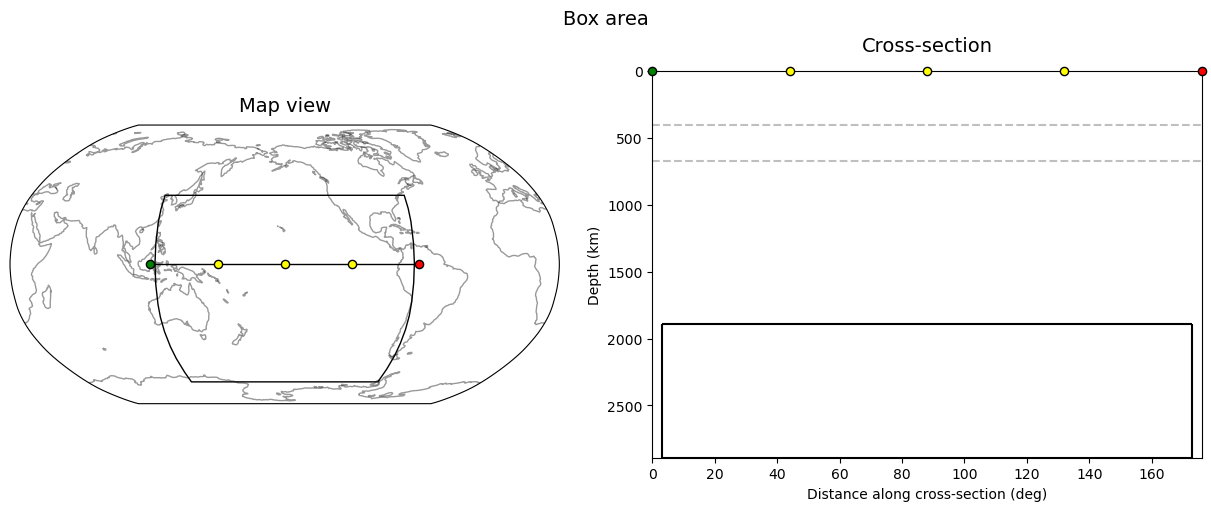

In [3]:
%%time
fig = plt.figure(figsize = (12,5), constrained_layout = True)
lats = np.arange(-90, 90, map_increment)
lons = np.arange(-180, 180, map_increment)
tomo_cm = 'RdBu'

# define map extents
w = box_sampling_input.west
s = box_sampling_input.south
e = w + box_sampling_input.width
if e >= 180.:
    e -= 360
n = s + box_sampling_input.height
if n >= 90.:
    print(f'--  Northern extent too large, n = {n}; adjust `height` variable in `box_sampling_input.py`')

map_center = w + (box_sampling_input.width / 2)
if map_center >= 180.:
    map_center -= 360

# define x-sec extents:
xsec_length = geo_math.GCP_length(start_point[0], start_point[1], end_point[0], end_point[1])
reference_dot_spacing = xsec_length / (number_of_reference_points + 1)
xsec_az = geo_math.azimuth(start_point[0], start_point[1], end_point[0], end_point[1])


## map view setup:
ax1 = fig.add_subplot(1, 2, 1, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)
ax1.plot([start_point[1], end_point[1]], [start_point[0], end_point[0]], c = 'k', transform = ccrs.Geodetic(), linewidth = 1, zorder = 2)
ax1.scatter(start_point[1], start_point[0], transform = ccrs.Geodetic(), c = 'green', marker = '.', edgecolor = 'black', s = 140, zorder = 3)
ax1.scatter(end_point[1], end_point[0], transform = ccrs.Geodetic(), c = 'red', marker = '.', edgecolor = 'black', s = 140, zorder = 3)

## cross-section view setup:
ax2 = fig.add_subplot(1, 2, 2)
ax2.annotate(f'Cross-section', xy = (0.5, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 14)
ax2.scatter(0., 0., c = 'green', marker = '.', edgecolor = 'black', s = 140, zorder = 3, clip_on = False)
ax2.scatter(xsec_length, 0., c = 'red', marker = '.', edgecolor = 'black', s = 140, zorder = 3, clip_on = False)
ax2.axhline(y = 400., c = 'k', linestyle = '--', alpha = 0.25)
ax2.axhline(y = 670., c = 'k', linestyle = '--', alpha = 0.25)
ax2.invert_yaxis()
ax2.set_ylim(2891, 0)
ax2.set_xlim(0, xsec_length)
ax2.set_ylabel('\nDepth (km)')
ax2.set_xlabel('Distance along cross-section (deg)')

## reference dots:
reference_dot_dist = 0
for reference_point in range(number_of_reference_points):
    reference_dot_dist += reference_dot_spacing
    reference_dot_coords = geo_math.GCP_point(start_point[0], start_point[1], end_point[0], end_point[1], xsec_length, reference_dot_dist)
    ax1.scatter(reference_dot_coords[1], reference_dot_coords[0], transform = ccrs.Geodetic(), c = 'yellow', marker = '.', edgecolor = 'black', s = 140, zorder = 3)
    ax2.scatter(reference_dot_dist, 0, c = 'yellow', marker = '.', edgecolor = 'black', s = 140, zorder = 3, clip_on = False)

## add model:
if model != None:
    ## map view:
    df_model = pd.read_csv(f'./models/{model}.csv')
    df_model = df_model.loc[df_model['depth'] >= 0]
    depths = list(df_model.depth.unique())
    depths.insert(0, 0)
    mod_dvs = lateral_grid_register(df_model, model_wave_type, model_depth, map_increment, model_value, model_value_type)
    im1 = ax1.pcolormesh(lons, lats, mod_dvs, transform = ccrs.PlateCarree(), cmap = tomo_cm, vmin = -tomo_bar_val, vmax = tomo_bar_val)
    ax1.annotate(f'Map view ({model_depth} km depth)', xy = (0.5, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 14)
    suptitle = f'Box area for model {model}'

    ## x-section:
    xsec_dvs = radial_grid_register(df_model, model_wave_type, start_point[0], start_point[1], end_point[0], end_point[1], map_increment, model_value, model_value_type)
    ax2.pcolormesh(range(0, len(xsec_dvs.T) + 1), depths, xsec_dvs, cmap = tomo_cm, vmin = -tomo_bar_val, vmax = tomo_bar_val)

    ## colorbar:
    cbar_tomo = fig.colorbar(im1, ax = [ax1, ax2], orientation = 'horizontal', shrink = 0.3, pad = 0.1, extend = 'both')
    cbar_tomo.ax.tick_params(labelsize = 12)
    cbar_tomo.ax.set_xlabel('dVs (%)', size = 12)
    
else:
    ax1.annotate(f'Map view', xy = (0.5, 1.05), ha = 'center', xycoords = 'axes fraction', fontsize = 14)
    zero_ar = np.zeros((1, 1))
    ax2.pcolormesh([0, xsec_length], [0, 2891], zero_ar, cmap = 'Greys', vmin = 0, vmax = 0)
    suptitle = f'Box area'

## add box outline:
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'black', fill = False, alpha = 1, transform = ccrs.PlateCarree()))


x_pts = []

# # find the coordinates of all of the boundaries from the start point
try:
    start_to_w = geo_math.known_lon(xsec_az, start_point[0], start_point[1], w)
    if start_to_w[2] <= xsec_length:
        x_pts.append(start_to_w[2])
except:
    pass
try:
    start_to_e = geo_math.known_lon(xsec_az, start_point[0], start_point[1], e)
    if start_to_e[2] <= xsec_length:
        x_pts.append(start_to_e[2])
except:
    pass
try:
    start_to_s = geo_math.known_lat(xsec_az, start_point[0], start_point[1], s)
    if start_to_s[2] <= xsec_length:
        x_pts.append(start_to_s[2])
except:
    pass
try:
    start_to_n = geo_math.known_lat(xsec_az, start_point[0], start_point[1], n)
    if start_to_n[2] <= xsec_length:
        x_pts.append(start_to_n[2])
except:
    pass
    
for x_pt in x_pts:
    ax2.vlines(x_pt, box_sampling_input.box_depth_min, box_sampling_input.box_depth_max, colors = 'k')

if len(x_pts) == 0:
    ax2.axhline(box_sampling_input.box_depth_min, c = 'k')
    ax2.axhline(box_sampling_input.box_depth_max, c = 'k')
elif len(x_pts) == 1:
    # find which side of the plot to draw the line to 
    if (s < start_point[0] < n) and ((w < start_point[1]) or (e > start_point[1])):
        ax2.hlines(box_sampling_input.box_depth_min, x_pts[0], 0, colors = 'k')
        ax2.hlines(box_sampling_input.box_depth_max, x_pts[0], 0, colors = 'k')
    elif (s < end_point[0] < n) and ((w < end_point[1]) or (e > end_point[1])):
        print('lj')
        ax2.hlines(box_sampling_input.box_depth_min, x_pts[0], xsec_length, colors = 'k')
        ax2.hlines(box_sampling_input.box_depth_max, x_pts[0], xsec_length, colors = 'k')
elif len(x_pts) == 2:
    ax2.hlines(box_sampling_input.box_depth_min, x_pts[0], x_pts[1], colors = 'k')
    ax2.hlines(box_sampling_input.box_depth_max, x_pts[0], x_pts[1], colors = 'k')

fig.suptitle(suptitle, fontsize = 14);
print(f'west: {w}, south: {s}, east: {e}, north: {n}')
print()

---
## PART 2: Filter dataset by individual measurement attributes

#### **`box_sampling.py` must be run before proceeding!**

In this part, the user can filter the dataset of individual measurements based on attributes including:

- Station location (`STA_LAT`, `STA_LON`)
- Any retained columns (e.g., quality weights) defined in `box_sampling_input.columns_to_keep`
- Phase (`PHASE`)
- Azimuth (`AZIMUTH`)
- Bottoming depth (km) (`MAX_DEPTH_KM`)
- Total length of raypaths (km) (`TOTAL_LENGTH_KM`)
- Length of the portion of the raypaths that pass through the box (`LENGTH_IN_BOX_KM`)
- Percent of the raypaths that pass through the box (`%_IN_BOX`)

Event-related filters (i.e., event location (`EQ_LAT`, `EQ_LON`), magnitude (`EQ_MAG`), depth (`EQ_DEP`)) can be added now or in later steps (recommended).

#### Define the dataset and print a preview:

In [4]:
df_data = pd.read_csv(box_sampling_input.dataset_save_name)
print(f'number of raypaths represented in the dataset before initial filtering: {len(df_data)}')
print()
display(df_data)

number of raypaths represented in the dataset before initial filtering: 262315



,EVENT_ID,EQ_LAT,EQ_LON,EQ_MAG,EQ_DEP,STA_LAT,STA_LON,PHASE,COMPREHENSIVE_WEIGHT,AZIMUTH,MEAN_AZ_IN_BOX,STD_AZ_IN_BOX,MAX_DEPTH_KM,TOTAL_LENGTH_KM,LENGTH_IN_BOX_KM,%_IN_BOX
0,1.994011e+13,-13.339,-69.446,6.9,596.0,-20.488,-45.639,ScSScS,0.274536,110.694483,NaN,NaN,2891.0,11139.831232,0.000000,0.000000
1,1.994011e+13,-13.339,-69.446,6.9,596.0,35.889,-120.426,ScSScS,0.271667,317.548897,317.410890,0.961740,2891.0,12319.521965,4828.689865,39.195432
2,1.994011e+13,-13.339,-69.446,6.9,596.0,36.764,-121.447,ScSScS,0.431167,317.797742,317.572735,1.053649,2891.0,12363.219670,4857.297029,39.288285
3,1.994011e+13,-13.339,-69.446,6.9,596.0,37.876,-122.236,ScSScS,0.285187,318.378067,318.045579,1.159199,2891.0,12406.549941,4885.778049,39.380634
4,1.994011e+13,-13.339,-69.446,6.9,596.0,41.732,-122.710,ScSScS,0.405000,321.455739,320.787029,1.453638,2891.0,12503.384601,4949.840025,39.588001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
262310,2.017022e+13,-23.259,-178.804,6.9,414.5,41.540,-81.360,ScSScSScSScS,0.050000,52.429272,52.044507,5.342212,2891.0,24465.078985,9038.362742,36.943934
262311,2.017022e+13,-23.259,-178.804,6.9,414.5,40.610,-79.170,ScSScSScSScS,0.050000,53.797319,53.192837,5.321461,2891.0,24507.945215,9064.908398,36.987631
262312,2.017022e+13,-23.259,-178.804,6.9,414.5,43.980,-75.650,ScSScSScSScS,0.050000,50.710303,47.866548,1.803462,2891.0,24606.928465,6844.811969,27.816604
262313,2.017022e+13,-23.259,-178.804,6.9,414.5,45.900,-75.610,ScSScSScSScS,0.050000,48.614048,46.156832,1.860336,2891.0,24616.617102,6849.339163,27.824047


#### Interactively apply any filters to the dataframe:

Note: this cell (as well as all future cells) creates a new copy of the dataframe everytime it's run, so i can be rerun it as many times as necessary to try new/different combinations of filters.

In [5]:
df_filtered_data = df_data.copy()

part1_headers = []
part1_values = []
part1_thresholds = []
part1_remaining = []

while True:
    add_filter = str(input(f'Do you have a filter to add? [y / n]: '))
    if add_filter == 'n':
        break
    
    elif add_filter == 'y':
        other_value_header = str(input(f'What is the header of the filter you would like to add?: '))
        while other_value_header not in df_data.columns:
            other_value_header = str(input(f'Sorry, that header is not in the dataframe. Is there another header you would like to try?: '))
        
        if other_value_header == 'PHASE':
            other_value_filter = str(input(f'What phase or phases would you like to apply a filter to (format is either `phase` or `phase1, phase2,...`)?: '))
            other_value_filter_type = str(input(f'Would you like to exclude {other_value_filter} or make a dataframe of raypaths that exclusively matches {other_value_filter}? [exclude / match]: '))
            
            if ', ' in other_value_filter:
                other_value_filter = other_value_filter.split(', ')

            if other_value_filter_type == 'exclude':
                if type(other_value_filter) == str:
                    df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header] != other_value_filter]
                elif type(other_value_filter) == list:
                    df_filtered_data = df_filtered_data.loc[~df_filtered_data[other_value_header].isin(other_value_filter)]
                    
            elif other_value_filter_type == 'match':
                if type(other_value_filter) == str:
                    df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header] == other_value_filter]
                elif type(other_value_filter) == list:
                    df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header].isin(other_value_filter)]
        
        else:
            other_value_filter = float(input(f'What is the value of the filter you would like to apply?: '))
            other_value_filter_type = str(input(f'Is the given value a maximum or minimum threshold? [max / min]: '))
            if other_value_filter_type == 'min':
                df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header] >= other_value_filter]
            elif other_value_filter_type == 'max':
                df_filtered_data = df_filtered_data.loc[df_filtered_data[other_value_header] <= other_value_filter]
        
        print(f'You have {len(df_filtered_data)} of {len(df_data)} raypaths in your filtered dataset')

        part1_headers.append(other_value_header)
        part1_values.append(other_value_filter)
        part1_thresholds.append(other_value_filter_type)
        part1_remaining.append(len(df_filtered_data))
        
        print()
    
    else:
        pass

df_filtered_data = df_filtered_data.reset_index(drop = True)
print()
print(f'You have {len(df_filtered_data)} of {len(df_data)} raypaths in your filtered dataset')
display(df_filtered_data)

Do you have a filter to add? [y / n]:  y
What is the header of the filter you would like to add?:  %_IN_BOX
What is the value of the filter you would like to apply?:  30
Is the given value a maximum or minimum threshold? [max / min]:  min


You have 52348 of 262315 raypaths in your filtered dataset



Do you have a filter to add? [y / n]:  y
What is the header of the filter you would like to add?:  COMPREHENSIVE_WEIGHT
What is the value of the filter you would like to apply?:  0.5
Is the given value a maximum or minimum threshold? [max / min]:  min


You have 24486 of 262315 raypaths in your filtered dataset



Do you have a filter to add? [y / n]:  n



You have 24486 of 262315 raypaths in your filtered dataset


,EVENT_ID,EQ_LAT,EQ_LON,EQ_MAG,EQ_DEP,STA_LAT,STA_LON,PHASE,COMPREHENSIVE_WEIGHT,AZIMUTH,MEAN_AZ_IN_BOX,STD_AZ_IN_BOX,MAX_DEPTH_KM,TOTAL_LENGTH_KM,LENGTH_IN_BOX_KM,%_IN_BOX
0,1.994011e+13,-13.339,-69.446,6.9,596.0,19.330,-99.178,ScS,0.541667,317.522762,318.494447,0.000000,2891.000000,6268.317423,2699.546085,43.066519
1,1.994011e+13,-13.339,-69.446,6.9,596.0,33.609,-116.455,ScS,0.500000,317.705267,318.854044,0.000000,2891.000000,7321.634347,3514.683315,48.004081
2,1.994011e+13,-13.339,-69.446,6.9,596.0,37.876,-122.236,ScS,0.560000,318.378067,319.535878,0.000000,2891.000000,7673.287619,3814.878832,49.716354
3,1.994011e+13,-13.339,-69.446,6.9,596.0,44.417,-121.689,S,0.904400,324.162103,325.172099,0.000000,2076.309911,7498.135136,2254.604347,30.068868
4,1.994011e+13,-13.339,-69.446,6.9,596.0,-17.569,-149.576,S,1.000000,254.753346,260.073916,0.000000,2153.294744,7672.811024,2680.628330,34.936718
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24481,2.017022e+13,-23.259,-178.804,6.9,414.5,40.170,-75.190,ScSScSScS,0.640000,54.917828,53.746771,4.319363,2891.000000,19370.649634,7502.702919,38.732325
24482,2.017022e+13,-23.259,-178.804,6.9,414.5,36.720,-89.470,ScSScSScSScS,0.810000,55.396837,53.212589,3.682810,2891.000000,24246.584708,8903.909940,36.722326
24483,2.017022e+13,-23.259,-178.804,6.9,414.5,33.860,-84.060,ScSScSScSScS,0.620000,59.639174,56.512695,3.490914,2891.000000,24342.322597,8962.647851,36.819198
24484,2.017022e+13,-23.259,-178.804,6.9,414.5,35.450,-84.520,ScSScSScSScS,0.730000,57.938368,55.362614,3.749393,2891.000000,24345.536836,8964.624621,36.822456


#### Display a dataframe showing the number of phases represented in the current filtered dataset:

In [6]:
unique_filtered_phases = df_filtered_data.PHASE.unique()
display(df_filtered_data.groupby(['PHASE']).size().reset_index())
total_unique_phases = len(unique_filtered_phases)

,PHASE,0
0,S,15600
1,SS,607
2,SSSm,4
3,ScS,2884
4,ScSScS,727
5,ScSScSScS,379
6,ScSScSScSScS,92
7,ScSScSScSScSScS,6
8,Sdiff,4187


---
## PART 3: Filter dataset by unique event attributes and compile a prioritized event dataset

Find all unique events to which the filtered raypaths belong and compute unique event attributes based on filtered raypaths.

New attributes/filtering criteria include the following:

- Event location (`EQ_LAT`, `EQ_LON`)
- Event magnitude (`EQ_MAG`)
- Event depth (`EQ_DEP`)
- Total number of raypaths associated with each unique event (`RAYPATHS`)
- Averages of any retained values from the input dataset to be considered (defined in `box_sampling_input.columns_to_keep`)
- The range of azimuths from 0-180 degrees covered by the raypaths associated with each unique event (`AZ_RANGE`)
- The mean of azimuthal spacing from 0-180 degrees between the raypaths associated with each unique event (`AZ_SPACING_MEAN`)
- The standard deviation of azimuthal spacing from 0-180 degrees between the raypaths associated with each unique event (`AZ_SPACING_STD`)
- The number of unique phases represented by the raypaths associated with each unique event (`UNIQUE_PHASES`)
- The epicentral distance of each unique event from the geographical center of all unique events (`DIST_FROM_CENTER`)
- The azimuth between the center and each unique event (`AZ_FROM_CENTER`)
- The cumulative epicentral distance between each event and every other event (`CUMULATIVE_DIST`)
- The cumulative azimuth between each event and every other event (`CUMULATIVE_AZ`)
- The normalized sum of the normalized cumulative distance and cumulative azimuth to represent how dispersed each event is (`DISPERSION_SCORE`)

#### Print a preview of the dataframe:

In [7]:
unique_events = df_filtered_data['EVENT_ID'].unique()
df_unique_events = pd.DataFrame(data = {'EVENT_ID': unique_events})
df_unique_events['EQ_LAT'] = 0.
df_unique_events['EQ_LON'] = 0.
df_unique_events['EQ_MAG'] = 0
df_unique_events['EQ_DEP'] = 0
df_unique_events['RAYPATHS'] = 0

for col in box_sampling_input.columns_to_keep:
    df_unique_events[col] = 0.
df_unique_events['AZ_RANGE'] = 0.
df_unique_events['AZ_SPACING_MEAN'] = 0.
df_unique_events['AZ_SPACING_STD'] = 0.
df_unique_events['UNIQUE_PHASES'] = 0

# for each event, add average weights from the input dataset
for event in range(len(df_unique_events)):
    event_id = df_unique_events['EVENT_ID'].iloc[event]
    df_event = df_filtered_data.loc[df_filtered_data['EVENT_ID'] == event_id].copy()
    df_unique_events.loc[event, 'EQ_MAG'] = df_event['EQ_MAG'].iloc[0]
    df_unique_events.loc[event, 'EQ_DEP'] = df_event['EQ_DEP'].iloc[0]
    df_unique_events.loc[event, 'UNIQUE_PHASES'] = len(df_event.PHASE.unique())
    df_unique_events.loc[event, 'EQ_LAT'] = df_event['EQ_LAT'].iloc[0]
    df_unique_events.loc[event, 'EQ_LON'] = df_event['EQ_LON'].iloc[0]
    df_unique_events.loc[event, 'RAYPATHS'] = len(df_event)

    for col in box_sampling_input.columns_to_keep:
        df_unique_events.loc[event, col] = df_event[col].mean()
    
    if len(df_event) == 1:
        df_unique_events.loc[event, 'AZ_RANGE'] = np.nan
        df_unique_events.loc[event, 'AZ_SPACING_MEAN'] = np.nan
        df_unique_events.loc[event, 'AZ_SPACING_STD'] = np.nan
        
    else:
        sorted_az = df_event['AZIMUTH'].apply(convert_azimuth).sort_values()        
        df_unique_events.loc[event, 'AZ_RANGE'] = sorted_az.max() - sorted_az.min()
        df_unique_events.loc[event, 'AZ_SPACING_MEAN'] = sorted_az.diff()[1:].mean()
        df_unique_events.loc[event, 'AZ_SPACING_STD'] = sorted_az.diff()[1:].std()


cloud_center = find_cloud_center(df_unique_events['EQ_LAT'], df_unique_events['EQ_LON'])

df_unique_events['DIST_FROM_CENTER'] = dist_from_point(cloud_center[0], cloud_center[1], df_unique_events['EQ_LAT'], df_unique_events['EQ_LON'])
df_unique_events['AZ_FROM_CENTER'] = az_from_point(cloud_center[0], cloud_center[1], df_unique_events['EQ_LAT'], df_unique_events['EQ_LON'])
df_unique_events['CUMULATIVE_DIST'] = 0
df_unique_events['CUMULATIVE_AZ'] = 0

for event in range(len(df_unique_events)):
    eq_lat = df_unique_events['EQ_LAT'].iloc[event]
    eq_lon = df_unique_events['EQ_LON'].iloc[event]
    az_from_center = df_unique_events['AZ_FROM_CENTER'].iloc[event]

    # find the cumulative epicentral distance to every other point
    df_unique_events.loc[event, 'CUMULATIVE_DIST'] = np.sum(dist_from_point(eq_lat, eq_lon, df_unique_events['EQ_LAT'], df_unique_events['EQ_LON']))

    # find the cumulative angle between this event, the cloud center, and every other event
    df_unique_events.loc[event, 'CUMULATIVE_AZ'] = np.sum(az_diff(az_from_center, df_unique_events['AZ_FROM_CENTER']))

df_unique_events['DISPERSION_SCORE'] = (df_unique_events['CUMULATIVE_DIST'] / df_unique_events['CUMULATIVE_DIST'].max()) + (df_unique_events['CUMULATIVE_AZ'] / df_unique_events['CUMULATIVE_AZ'].max())
df_unique_events['DISPERSION_SCORE'] = df_unique_events['DISPERSION_SCORE'] / df_unique_events['DISPERSION_SCORE'].max()
df_unique_events = df_unique_events.sort_values(by = ['DISPERSION_SCORE'], ascending = False).reset_index(drop = True)

print(f'There are {len(df_unique_events)} unique events from the filtered raypaths')
print()
display(df_unique_events)

There are 264 unique events from the filtered raypaths



,EVENT_ID,EQ_LAT,EQ_LON,EQ_MAG,EQ_DEP,RAYPATHS,COMPREHENSIVE_WEIGHT,AZ_RANGE,AZ_SPACING_MEAN,AZ_SPACING_STD,UNIQUE_PHASES,DIST_FROM_CENTER,AZ_FROM_CENTER,CUMULATIVE_DIST,CUMULATIVE_AZ,DISPERSION_SCORE
0,2.009031e+13,80.324,-1.853,6.5,9.00,1,0.609583,NaN,NaN,NaN,1,102.521953,1.185782,25624.604225,26757.087953,1.000000
1,2.006093e+13,10.876,-61.756,6.1,53.00,58,0.529660,60.379680,1.059293,4.505686,2,113.320064,79.410740,26464.776478,25482.083635,0.992235
2,2.013101e+13,10.905,-62.315,6.0,63.00,20,0.542879,60.705021,3.195001,10.105329,2,112.770570,79.394461,26390.172559,25482.278983,0.990795
3,2.014011e+13,19.043,-66.810,6.4,20.00,56,0.693625,125.539360,2.282534,6.569973,4,108.090580,70.910597,25843.882523,25698.130946,0.984291
4,2.015031e+13,6.776,-72.988,6.2,155.00,13,0.715763,178.104556,14.842046,20.377834,4,102.213017,83.693543,24909.311159,25421.353463,0.960991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259,2.014123e+13,-20.326,-178.564,6.0,599.28,267,0.822613,167.331619,0.629066,2.345187,4,17.761881,191.173638,16446.350288,20345.841209,0.701596
260,2.014072e+13,-19.802,-178.400,6.9,615.42,850,0.915955,169.988234,0.200222,0.789593,4,17.217442,191.028864,16440.951836,20347.542353,0.701524
261,2.014072e+13,-19.802,-178.400,6.9,615.42,189,0.766825,46.882940,0.249377,0.674760,3,17.217442,191.028864,16440.951836,20347.542353,0.701524
262,2.004072e+13,-17.656,-178.760,7.0,565.50,67,0.826023,121.463837,1.840361,4.379006,5,15.205175,193.971673,16444.009949,20334.392550,0.701335


#### Plot a histogram and corresponding map of events showing the distribution of any header per unique event

In [10]:
header_to_plot = 'UNIQUE_PHASES'

Text(0.5, 0, 'UNIQUE_PHASES')

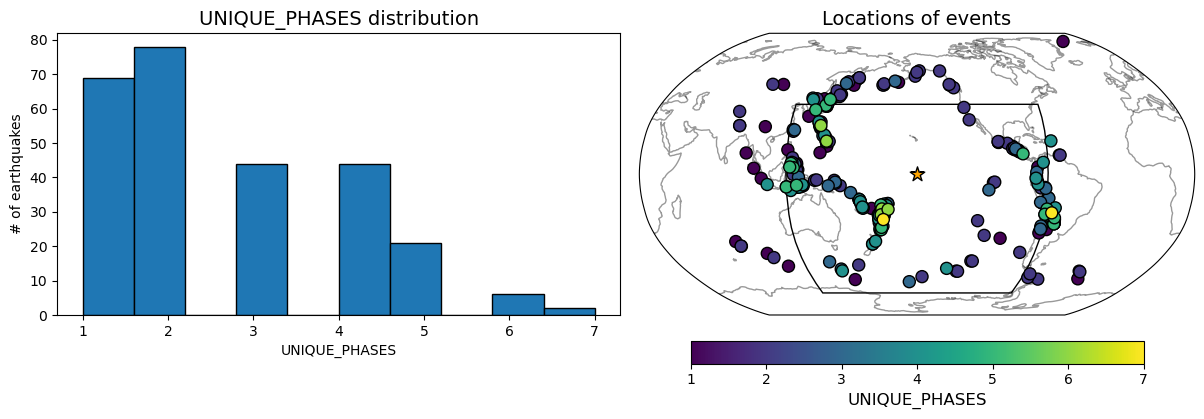

In [11]:
ascending_kw = True
cm = 'viridis'

df_unique_events = df_unique_events.sort_values(by = [header_to_plot], ascending = ascending_kw).reset_index(drop = True)

fig = plt.figure(figsize = (12, 4), constrained_layout = True)
ax0 = fig.add_subplot(1, 2, 1)#, aspect = 2)
ax0.set_box_aspect(.5)
ax0.hist(df_unique_events[header_to_plot], edgecolor = 'k')
ax0.set_title(f'{header_to_plot} distribution', fontsize = 14)
ax0.set_xlabel(f'{header_to_plot}')
ax0.set_ylabel('# of earthquakes');

ax1 = fig.add_subplot(1, 2, 2, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)
ax1.scatter(cloud_center[1], cloud_center[0], c = 'orange', marker = '*', s = 120, edgecolor = 'k')
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'black', fill = False, alpha = 1, transform = ccrs.PlateCarree()))
ax1.set_title(f'Locations of events', fontsize = 14)
im1 = ax1.scatter(df_unique_events['EQ_LON'], df_unique_events['EQ_LAT'], c = df_unique_events[header_to_plot], transform = ccrs.PlateCarree(), edgecolor = 'k', marker = 'o', s = 75, cmap = cm, alpha = 1, zorder = 2)
cbar = fig.colorbar(im1, ax = [ax1], orientation = 'horizontal', shrink = 0.8, pad = -0.05)
cbar.ax.set_xlabel(f'{header_to_plot}', size = 12)


#### Apply any initial filters before applying prioritization weights:

In [14]:
df_filtered_events = df_unique_events.copy()

part2_headers = []
part2_values = []
part2_thresholds = []
part2_remaining = []

while True:
    add_filter = str(input(f'Do you have a filter to add? [y / n]: '))
    if add_filter == 'n':
        break
    
    elif add_filter == 'y':
        other_value_header = str(input(f'What is the header in the dataframe of unique events of the filter you would like to add?: '))
        
        while other_value_header not in df_filtered_events.columns:
            other_value_header = str(input(f'Sorry, that header is not in the dataframe. Is there another header you would like to try?: '))
            
        other_value_filter = float(input(f'What is the value of the filter you would like to apply?: '))
        other_value_filter_type = str(input(f'Is the given value a maximum or minimum threshold? [max / min]: '))
        if other_value_filter_type == 'min':
            df_filtered_events = df_filtered_events.loc[df_filtered_events[other_value_header] >= other_value_filter]
        elif other_value_filter_type == 'max':
            df_filtered_events = df_filtered_events.loc[df_filtered_events[other_value_header] <= other_value_filter]

        print(f'You have {len(df_filtered_events)} of {len(df_unique_events)} events in your filtered dataset')

        part2_headers.append(other_value_header)
        part2_values.append(other_value_filter)
        part2_thresholds.append(other_value_filter_type)
        part2_remaining.append(len(df_filtered_events))
        
        print()
    
    else:
        pass

df_filtered_events = df_filtered_events.reset_index(drop = True)
print()
print(f'You have {len(df_filtered_events)} of {len(df_unique_events)} events in your filtered dataset')
display(df_filtered_events)

Do you have a filter to add? [y / n]:  y
What is the header in the dataframe of unique events of the filter you would like to add?:  EQ_MAG
What is the value of the filter you would like to apply?:  7
Is the given value a maximum or minimum threshold? [max / min]:  max


You have 242 of 264 events in your filtered dataset



Do you have a filter to add? [y / n]:  y
What is the header in the dataframe of unique events of the filter you would like to add?:  RAYPATHS
What is the value of the filter you would like to apply?:  20
Is the given value a maximum or minimum threshold? [max / min]:  min


You have 113 of 264 events in your filtered dataset



Do you have a filter to add? [y / n]:  n



You have 113 of 264 events in your filtered dataset


,EVENT_ID,EQ_LAT,EQ_LON,EQ_MAG,EQ_DEP,RAYPATHS,COMPREHENSIVE_WEIGHT,AZ_RANGE,AZ_SPACING_MEAN,AZ_SPACING_STD,UNIQUE_PHASES,DIST_FROM_CENTER,AZ_FROM_CENTER,CUMULATIVE_DIST,CUMULATIVE_AZ,DISPERSION_SCORE
0,2.013101e+13,-36.727,-97.476,6.2,10.28,30,0.840600,174.212786,6.007337,25.743106,1,78.226331,126.943354,21916.079371,23497.209525,0.866816
1,2.010111e+13,-45.464,96.394,6.5,10.00,149,0.736487,38.165718,0.257876,0.299414,1,86.978917,224.598971,23101.277098,20808.973418,0.839100
2,2.008041e+13,-56.022,-28.035,6.0,140.20,38,0.707863,8.594372,0.232280,0.331742,1,115.178828,160.298843,26371.787010,22000.717386,0.924841
3,2.013051e+13,-19.622,175.051,6.0,11.00,24,0.639460,110.408614,4.800375,12.978350,1,19.350441,209.577960,16530.301788,20565.334850,0.707356
4,2.007102e+13,-25.775,179.530,6.6,509.30,25,0.668000,9.372949,0.390540,0.300879,1,23.465228,192.565503,16636.990313,20332.411408,0.705032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2.005032e+13,-24.983,-63.470,6.9,579.10,75,0.806260,132.243694,1.787077,4.079058,5,108.058179,117.478999,25116.727284,23714.729812,0.932850
109,1.998071e+13,-30.487,-178.994,6.9,129.50,36,0.827180,158.628716,4.532249,10.366513,5,27.833768,187.479530,16927.128661,20446.995422,0.712805
110,2.011083e+13,-6.362,126.752,6.9,469.80,170,0.879523,175.915945,1.040923,5.276886,5,58.182040,264.320968,19944.311329,22117.094617,0.802657
111,2.017022e+13,-23.259,-178.804,6.9,414.50,596,0.846929,170.897819,0.287223,1.260657,6,20.680977,190.071129,16523.380540,20365.014042,0.703448


#### Plot remaining filtered events based on any header in the filtered dataset of unique events:

In [15]:
filtered_header_to_plot = 'EQ_MAG'

Text(0.5, 0.98, 'Locations of filtered events')

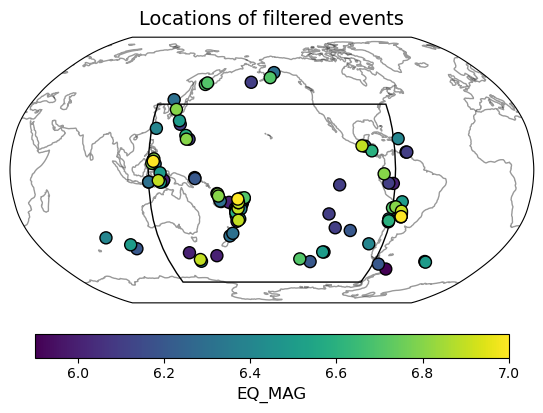

In [16]:
df_filtered_events = df_filtered_events.sort_values(by = [filtered_header_to_plot], ascending = True).reset_index(drop = True)

fig = plt.figure(figsize = (6, 4), constrained_layout = True)

cm = 'viridis'
ax1 = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'black', fill = False, alpha = 1, transform = ccrs.PlateCarree()))
im1 = ax1.scatter(df_filtered_events['EQ_LON'], df_filtered_events['EQ_LAT'], c = df_filtered_events[filtered_header_to_plot], transform = ccrs.PlateCarree(), edgecolor = 'k', marker = 'o', s = 75, cmap = cm, alpha = 1, zorder = 2)
cbar = fig.colorbar(im1, ax = [ax1], orientation = 'horizontal', shrink = 0.8, pad = 0.1)
cbar.ax.set_xlabel(f'{filtered_header_to_plot}', size = 12)

fig.suptitle(f'Locations of filtered events', fontsize = 14)

#### Finally, apply priority weights to order the data based on unique event attributes:

In this step, priority weights can be added for any header. Weight values can be added between 0 and 1, where 0 indicates a weight that is negligible and 1 indicates a weight that is top priority. For example, if the number of raypaths per event is extremely important, a priority weight of 1 would be given for the header `RAYPATHS`. However, if the number of unique phases is _also_ important, but perhaps not as important as the number of raypaths, a priority weight of 0.5 could be assigned to the header `UNIQUE_PHASES`. If no weight is given to a header, its values are not considered in reordering/reprioritizing the dataframe of unique events. In this way, the unique events can be ordered according to different combinations of weights and attributes to find an optimal set of events.

Once all prioritization weights are applied, there will be an option for applying a cutoff for the total number of events desired.

In [17]:
df_prioritized = df_filtered_events.copy()
df_prioritized['PRIORITY'] = 0.

part3_headers = []
part3_favors = []
part3_weights = []

while True:
    add_headers = str(input(f'Do you want to add a priority to the filtered event dataframe? [y / n]: '))
    
    if add_headers == 'y':
        priority_header = str(input(f'What is the header of the column you would like to prioritize by?: '))
        priority_favor = str(input(f'Would you like to prioritize high or low values? [high / low]: '))
        priority_weight = float(input(f'What weight would you like to use for this priority? [0 < weight <= 1]: '))
                
        if priority_favor == 'high':
            weighted_priority = (df_prioritized[priority_header] / df_prioritized[priority_header].max()) * priority_weight
        elif priority_favor == 'low':
            weighted_priority = (df_prioritized[priority_header].min() / df_prioritized[priority_header]) * priority_weight
            
        df_prioritized['PRIORITY'] += weighted_priority

        part3_headers.append(priority_header)
        part3_favors.append(priority_favor)
        part3_weights.append(priority_weight)
        
    elif add_headers == 'n':
        break
    print()

df_prioritized['PRIORITY'] = df_prioritized['PRIORITY'] / df_prioritized['PRIORITY'].max()
df_prioritized = df_prioritized.sort_values(by = ['PRIORITY'], ascending = False).reset_index(drop = True)

print()
add_cutoff = str(input(f'Would you like to apply a cutoff for the total number of events to include in the final prioritized list? [y / n]: '))
if add_cutoff == 'y':
    cutoff_max = int(input(f'How many total events would you like to include in the final list?: '))
    df_prioritized = df_prioritized.iloc[:cutoff_max]

df_prioritized_raypaths = df_filtered_data.loc[df_filtered_data['EVENT_ID'].isin(df_prioritized['EVENT_ID'])]
display(df_prioritized)

Do you want to add a priority to the filtered event dataframe? [y / n]:  y
What is the header of the column you would like to prioritize by?:  DISPERSION_SCORE
Would you like to prioritize high or low values? [high / low]:  high
What weight would you like to use for this priority? [0 < weight <= 1]:  1


Do you want to add a priority to the filtered event dataframe? [y / n]:  y
What is the header of the column you would like to prioritize by?:  COMPREHENSIVE_WEIGHT
Would you like to prioritize high or low values? [high / low]:  high
What weight would you like to use for this priority? [0 < weight <= 1]:  1


Do you want to add a priority to the filtered event dataframe? [y / n]:  n


Would you like to apply a cutoff for the total number of events to include in the final prioritized list? [y / n]:  100


,EVENT_ID,EQ_LAT,EQ_LON,EQ_MAG,EQ_DEP,RAYPATHS,COMPREHENSIVE_WEIGHT,AZ_RANGE,AZ_SPACING_MEAN,AZ_SPACING_STD,UNIQUE_PHASES,DIST_FROM_CENTER,AZ_FROM_CENTER,CUMULATIVE_DIST,CUMULATIVE_AZ,DISPERSION_SCORE,PRIORITY
0,2.006111e+13,-26.052,-63.283,6.8,572.0,468,0.953571,101.243456,0.216795,1.815692,5,107.993531,118.615068,25109.505360,23681.642410,0.932086,1.000000
1,2.007122e+13,-22.954,-70.182,6.7,45.0,376,0.953429,156.224052,0.416597,3.827232,5,102.389859,114.267971,24373.062311,23807.592034,0.920209,0.993698
2,2.015053e+13,56.594,-156.430,6.7,72.6,33,0.924381,76.347108,2.385847,5.338852,2,61.386880,11.490455,20950.672470,27176.728780,0.917462,0.976680
3,1.994051e+13,-28.501,-63.096,6.9,600.5,20,0.907500,112.566709,5.924564,15.870223,5,107.602671,121.160218,25077.046797,23611.065431,0.930129,0.974265
4,2.007072e+13,-22.151,-65.777,6.4,289.5,569,0.895949,144.738480,0.254821,2.669932,7,106.534423,114.139025,24904.527074,23812.491995,0.930585,0.968310
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,2.007102e+13,-25.775,179.530,6.6,509.3,25,0.668000,9.372949,0.390540,0.300879,1,23.465228,192.565503,16636.990313,20332.411408,0.705032,0.727826
109,2.007011e+13,-18.580,-177.847,6.3,406.8,96,0.650693,152.359133,1.603780,4.620630,3,15.917420,190.061463,16445.313529,20365.246026,0.701942,0.716924
110,2.007041e+13,-20.202,-178.084,6.0,607.7,113,0.648753,136.367560,1.217567,5.617834,3,17.552977,189.796421,16448.117795,20372.137115,0.702126,0.715980
111,2.013051e+13,-19.622,175.051,6.0,11.0,24,0.639460,110.408614,4.800375,12.978350,1,19.350441,209.577960,16530.301788,20565.334850,0.707356,0.713738


#### Plot the filtered events with respect to their new priority score:

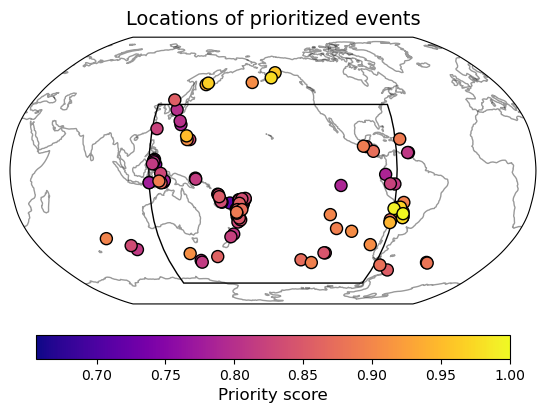

In [18]:
df_prioritized = df_prioritized.sort_values(by = ['PRIORITY'], ascending = True).reset_index(drop = True)
fig = plt.figure(figsize = (6, 4), constrained_layout = True)

ax1 = fig.add_subplot(1, 1, 1, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'black', fill = False, alpha = 1, transform = ccrs.PlateCarree()))
cm = 'plasma'
im1 = ax1.scatter(df_prioritized['EQ_LON'], df_prioritized['EQ_LAT'], c = df_prioritized['PRIORITY'], transform = ccrs.PlateCarree(), edgecolor = 'k', marker = 'o', s = 75, cmap = cm, alpha = 1, zorder = 2)
cbar = fig.colorbar(im1, ax = [ax1], orientation = 'horizontal', shrink = 0.8, pad = 0.1)
cbar.ax.set_xlabel('Priority score', size = 12)

fig.suptitle(f'Locations of prioritized events', fontsize = 14)
fig.savefig('./tech_review_plots/access_CH_priority_events.png', dpi = 300, transparent = True)

#### Plot the total and azimuthal coverage of the prioritized list of events:

First, compute the gridded total and azimuthal sampling (note, this can take a few minutes).

In [19]:
block_height = 2
df_grid = make_equal_area_grid(block_height, s, w, n, e)
ar_grid = np.array(df_grid)

df_grid_count = df_grid[['BLOCK#']].copy()
df_grid_count['TOTAL_PATHS'] = 0
df_grid_count['TOTAL_SECTORS'] = 0
df_grid_count['SECTOR_1'] = 0
df_grid_count['SECTOR_2'] = 0
df_grid_count['SECTOR_3'] = 0
df_grid_count['SECTOR_4'] = 0
df_grid_count['SECTOR_5'] = 0
df_grid_count['SECTOR_6'] = 0

ar_grid_count = np.array(df_grid_count)
ar_prioritized = np.array(df_prioritized)

event_ct = 1
for event in ar_prioritized[:, 0]:
    event_ct += 1
    ar_event =  np.loadtxt(f'./event_files/{event}.csv', skiprows = 1, delimiter = ',', usecols = (3, 4, 7, 8))
    
    for line in range(len(ar_event)):
        entry_lat = ar_event[line, 0]
        entry_lon = ar_event[line, 1]
        exit_lat = ar_event[line, 2]
        exit_lon = ar_event[line, 3]
        dist = geo_math.GCP_length(entry_lat, entry_lon, exit_lat, exit_lon)
        segment_blocks = []
        
        progress = 0
        run = True
        while run == True:
            progress += 1
            if progress < dist:
                seg_mid_point = geo_math.GCP_point(entry_lat, entry_lon, exit_lat, exit_lon, dist, progress / 2)
                seg_mid_point_block = find_block_id(seg_mid_point[0], seg_mid_point[1], ar_grid)
                seg_mid_point_block_id = np.where(ar_grid_count.T[0] == seg_mid_point_block)[0]
                
                if seg_mid_point_block_id not in segment_blocks:
                    seg_mid_point_az = geo_math.azimuth(seg_mid_point[0], seg_mid_point[1], exit_lat, exit_lon)
                    seg_mid_point_sector = azimuthal_sector(seg_mid_point_az)
                    ar_grid_count[seg_mid_point_block_id, 1] += 1
                    ar_grid_count[seg_mid_point_block_id, seg_mid_point_sector + 2] += 1
                    segment_blocks.append(seg_mid_point_block_id)
                else:
                    pass
            else:
                run = False

for count in range(len(ar_grid_count)):
    sector_array = ar_grid_count[count, 3:]
    sector_count = np.count_nonzero(sector_array)
    ar_grid_count[count, 2] = sector_count

df_grid_count = pd.DataFrame(ar_grid_count, columns = df_grid_count.columns)

Once the sampling is computed, plot the coverage maps. Total coverage is defined as the number of paths that sample a given grid area. Azimuthal coverage is defined as the number of azimuthal sectors (defined as six 30 degree sectors from 0 - 180 degrees) with coverage in a given grid area.

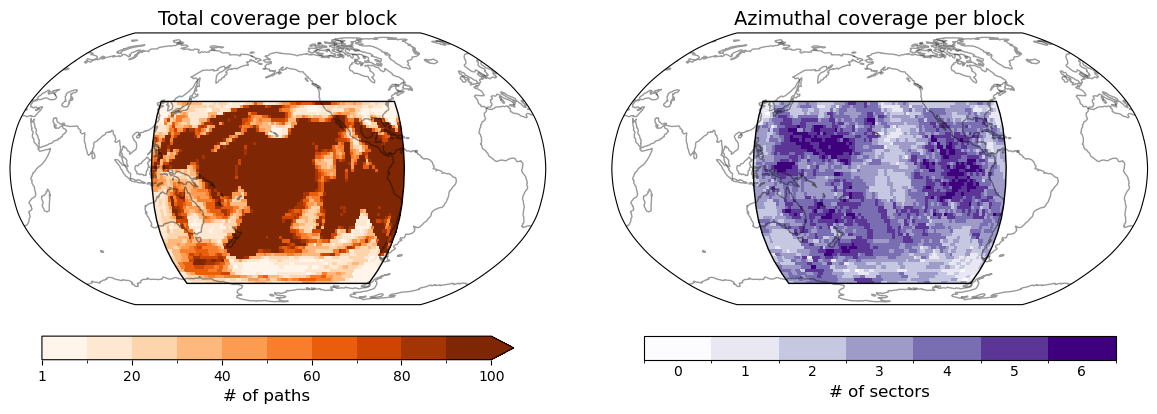

In [20]:
fig = plt.figure(figsize = (12, 4), constrained_layout = True)
box_lats = np.arange(s, n + block_height, block_height)
box_lons = np.arange(0, box_sampling_input.width + block_height, block_height)
box_lons = box_lons + w
box_lons[np.where(box_lons >= 180)[0]] = box_lons[np.where(box_lons >= 180)[0]] - 360

## total coverage:
ax1 = fig.add_subplot(1, 2, 1, projection = ccrs.Robinson(central_longitude = map_center))
ax1.set_global()
ax1.coastlines(alpha = 0.4)

cov_bins = [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
total_paths = coverage_mesh(ar_grid, ar_grid_count, block_height, 1)
cov_norm = mpl.colors.BoundaryNorm(cov_bins, mpl.cm.Oranges.N)
im1 = ax1.pcolormesh(box_lons, box_lats, total_paths, transform = ccrs.PlateCarree(), cmap = 'Oranges', norm = cov_norm)
ax1.set_title(f'Total coverage per block', fontsize = 14)
ax1.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'k', fill = False, alpha = 1, transform = ccrs.PlateCarree(), linewidth = 1))

cov_cbar_coverage = fig.colorbar(im1, ax = ax1, orientation = 'horizontal', shrink = 0.8, pad = 0.1, extend = 'max')
cov_cbar_coverage.ax.tick_params(labelsize = 10)
cov_cbar_coverage.ax.set_xlabel('# of paths', size = 12)

## azimuthal coverage:
ax2 = fig.add_subplot(1, 2, 2, projection = ccrs.Robinson(central_longitude = map_center))
ax2.set_global()
ax2.coastlines(alpha = 0.4)

sector_bins = list(range(0, azimuthal_sectors + 2, 1))
total_sectors = coverage_mesh(ar_grid, ar_grid_count, block_height, 2)
sector_norm = mpl.colors.BoundaryNorm(sector_bins, mpl.cm.Purples.N)
im2 = ax2.pcolormesh(box_lons, box_lats, total_sectors, transform = ccrs.PlateCarree(), cmap = 'Purples', norm = sector_norm)
ax2.set_title(f'Azimuthal coverage per block', fontsize = 14)
ax2.add_patch(mpatches.Rectangle(xy = [w, s], width = box_sampling_input.width, height = box_sampling_input.height, edgecolor = 'k', fill = False, alpha = 1, transform = ccrs.PlateCarree(), linewidth = 1))

sector_cbar_coverage = fig.colorbar(im2, ax = ax2, orientation = 'horizontal', shrink = 0.8, pad = 0.1, extend = 'neither')
sector_cbar_coverage.set_ticks([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5])
sector_cbar_coverage.set_ticklabels(sector_bins[:-1])
sector_cbar_coverage.ax.tick_params(labelsize = 10, size = 0)
sector_cbar_coverage.ax.set_xlabel('# of sectors', size = 12);

#### Finally, indicate if you would like to retain this list of events and filtering/prioritization parameters:

In [21]:
# query for whether to save files:
save_files = str(input(f'Would you like to save this list of events and associated filters/weights? [y / n]: '))

if save_files == 'y':
    filename = str(input(f'Give your list a short name with no spaces to be used for the file name (e.g., list_for_hawaii_model): '))
    try:
        os.mkdir(f'./events_lists')
    except:
        pass
    df_prioritized.to_csv(f'./events_lists/{filename}_events.csv', index = False)
    df_prioritized_raypaths.to_csv(f'./events_lists/{filename}_raypaths.csv', index = False)
    with open(f'./events_lists/{filename}_params.txt', 'w') as fout:
        fout.write(f'====================\n')
        fout.write(f'Input file parameters:\n')
        fout.write(f'Box width (lon. extent): {box_sampling_input.width}\n')
        fout.write(f'Box height (lat. extent): {box_sampling_input.height}\n')
        fout.write(f'Southernmost box latitude: {box_sampling_input.south}\n')
        fout.write(f'Westernmost box longitude: {box_sampling_input.west}\n')
        fout.write(f'Box minimum depth: {box_sampling_input.box_depth_min}\n')
        fout.write(f'Box maximum depth: {box_sampling_input.box_depth_max}\n')
        fout.write(f'Input raypath dataset name: {box_sampling_input.dataset_input_name}\n')
        fout.write(f'Input raypath dataset columns retained: {box_sampling_input.columns_to_keep}\n')
        fout.write(f'Output raypath dataset name: {box_sampling_input.dataset_save_name}\n')
        
        fout.write(f'\n====================\n')
        fout.write(f'Plotting parameters:\n')
        fout.write(f'Model background: {model}\n')
        if model != None:
            fout.write(f'Model wave type: {model_wave_type}\n')
            fout.write(f'Model depth: {model_depth}\n')
            fout.write(f'Model value: {model_value}\n')
            fout.write(f'Model value type: {model_value_type}\n')
            fout.write(f'Map increment: {map_increment}\n')
            fout.write(f'Colorbar min/max value: {tomo_color_bar}\n')
        fout.write(f'Cross-section start point: {start_point}\n')
        fout.write(f'Cross-section end point: {end_point}\n')
        fout.write(f'Number of reference points in cross-section: {number_of_reference_points}\n')
        
        fout.write(f'\n====================\n')
        fout.write(f'Part 1 - Individual raypath filtering:\n')
        for filter in range(len(part1_headers)):
            fout.write(f'Filter # {filter + 1}:\n')
            fout.write(f'  Filter header: {part1_headers[filter]}\n')
            fout.write(f'  Filter value: {part1_values[filter]}\n')
            fout.write(f'  Filter type: {part1_thresholds[filter]}\n')
            fout.write(f'  Remaining raypaths after filter: {part1_remaining[filter]} of {len(df_data)}\n')

        fout.write(f'\n====================\n')
        fout.write(f'Part 2 - Unique event filtering:\n')
        for filter in range(len(part2_headers)):
            fout.write(f'Filter # {filter + 1}:\n')
            fout.write(f'  Filter header: {part2_headers[filter]}\n')
            fout.write(f'  Filter value: {part2_values[filter]}\n')
            fout.write(f'  Filter type: {part2_thresholds[filter]}\n')
            fout.write(f'  Remaining events after filter: {part2_remaining[filter]} of {len(df_data)}\n')

        fout.write(f'\n====================\n')
        fout.write(f'Part 3 - Priority weights:\n')
        for filter in range(len(part3_headers)):
            fout.write(f'Priority weight # {filter + 1}:\n')
            fout.write(f'  Prioritized value header: {part3_headers[filter]}\n')
            fout.write(f'  Prioritized value favor: {part3_favors[filter]}\n')
            fout.write(f'  Priority weight: {part3_weights[filter]}\n')

elif save_files == 'n':
    print('List of prioritized events and associated filters/weights not saved.')
    

Would you like to save this list of events and associated filters/weights? [y / n]:  y
Give your list a short name with no spaces to be used for the file name (e.g., list_for_hawaii_model):  test_list
